<a href="https://colab.research.google.com/github/thunder913/Deep-Learning/blob/main/stocks_deep_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [102]:
import kagglehub
import numpy as np
import os
import pandas as pd
import kagglehub
import matplotlib.pyplot as plt
import pickle

from sklearn.preprocessing import LabelEncoder

In [16]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


# Stocks LSTM Prediction

In [19]:
google_drive_path = 'drive/MyDrive/DL_Pickles/'
local_path = './pickles/'

path = kagglehub.dataset_download("tsaustin/us-historical-stock-prices-with-earnings-data")

stock_prices_path = f"{path}/stocks_latest/stock_prices_latest.csv"

stock_data_path = f"./{google_drive_path}/stock_data_processed.pkl"

In [147]:
def calculate_rsi(group, period = 14):
    delta = group['close'].diff()

    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(window=period, min_periods=1).mean()
    avg_loss = loss.rolling(window=period, min_periods=1).mean()

    rs = avg_gain / avg_loss

    group['RSI'] = 100 - (100 / (1 + rs))
    return group

def calculate_macd(group, short_window=12, long_window=26, signal_window=9):
    # Calculate EMA short and long
    ema_short = group['close'].ewm(span=short_window, adjust=False).mean()
    ema_long = group['close'].ewm(span=long_window, adjust=False).mean()

    # Calculate MACD and Signal Line
    group['MACD'] = ema_short - ema_long
    group['Signal_Line'] = group['MACD'].ewm(span=signal_window, adjust=False).mean()

    return group

In [64]:
def get_peak_price_and_days_ago(df):
    """
    Calculate the peak price over a rolling 90-day window and determine the number of days
    since the peak price for each row in the DataFrame.
    """

    df['peak_price'] = df['close'].rolling(window=90, min_periods=1).max()
    peak_day_index = df['close'].rolling(window=90, min_periods=1).apply(lambda x: (len(x) - 1 - x.argmax()), raw=False)
    df['peak_days_ago'] = peak_day_index.fillna(0).astype(int)  # Fill NaN for rows that don't have enough data
    return df

def process_ticker_data(df):
    """
    Add historical price features for specific days ago for each stock (grouped by ticker).
    Also calculate the peak price and days since the peak price for each stock.
    """

    print('Calculated RSI')
    # Calculate RSI (14-day by default)
    df = df.groupby('ticker', group_keys=False).apply(calculate_rsi)

    print('Calculated moving averages')
    # Add moving averages
    moving_average_windows = [5, 10, 20, 50, 100, 200]  # Specify moving average windows
    for window in moving_average_windows:
        df[f'{window}_day_MA'] = df.groupby('ticker')['close'].rolling(window=window, min_periods=1).mean().reset_index(level=0, drop=True)

    print('Calculated MACD')
    # Calculate MACD and Signal Line

    df = df.groupby('ticker', group_keys=False).apply(calculate_macd)

    print('Calculated price days ago')
    # Add columns for prices X days ago
    for days in [1,2,3,4,5, 10, 15, 30, 60, 90]:
        df[f'price_{days}_days_ago'] = df.groupby('ticker')['close'].shift(days)

    df = df.groupby('ticker', group_keys=False).apply(get_peak_price_and_days_ago)

    # Remove the first 200 rows for each ticker
    df = df.groupby('ticker').apply(lambda group: group.iloc[200:]).reset_index(drop=True)

    return df

In [60]:
def getTidiedStockData():
    """
    Read and tidy the stock data dataset. If the processed stock data already exists as a pickle file,
    it loads and returns the data. Otherwise, it processes the raw stock data, cleans it, adds features,
    and saves the tidy data to a pickle file for future use.
    """

    # Check if the file exists
    if os.path.exists(stock_data_path):
        return pd.read_pickle(stock_data_path)

    # Read the basic data and some tidying
    stock_data = pd.read_csv(stock_prices_path)
    stock_data_tidy = stock_data

    stock_data_tidy.date = pd.to_datetime(stock_data_tidy.date)
    stock_data_tidy = stock_data_tidy.rename(columns={'symbol': 'ticker'})
    stock_data_tidy = stock_data_tidy.drop(columns=['split_coefficient'])

    stock_data_tidy = stock_data_tidy.sort_values(by=['ticker', 'date'], ascending=[True, True])

    stock_data_tidy = process_ticker_data(stock_data_tidy)

    stock_data_tidy = stock_data_tidy[stock_data_tidy.price_90_days_ago.isna() == False]

    # Encode labels
    le = LabelEncoder()
    stock_data_tidy['ticker_encoded'] = le.fit_transform(stock_data_tidy['ticker'])

    stock_data_tidy.to_pickle(stock_data_path)

    return stock_data_tidy

In [66]:
stock_data_tidy = getTidiedStockData()

Calculated RSI


<ipython-input-64-67f089c023e1>:20: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('ticker', group_keys=False).apply(calculate_rsi)


Calculated moving averages
Calculated MACD


<ipython-input-64-67f089c023e1>:31: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('ticker', group_keys=False).apply(calculate_macd)


Calculated price days ago


<ipython-input-64-67f089c023e1>:38: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('ticker', group_keys=False).apply(get_peak_price_and_days_ago)
<ipython-input-64-67f089c023e1>:41: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('ticker').apply(lambda group: group.iloc[200:]).reset_index(drop=True)


In [152]:
stock_data_tidy.columns

Index(['ticker', 'date', 'open', 'high', 'low', 'close', 'close_adjusted',
       'volume', 'RSI', '5_day_MA', '10_day_MA', '20_day_MA', '50_day_MA',
       '100_day_MA', '200_day_MA', 'MACD', 'Signal_Line', 'price_1_days_ago',
       'price_2_days_ago', 'price_3_days_ago', 'price_4_days_ago',
       'price_5_days_ago', 'price_10_days_ago', 'price_15_days_ago',
       'price_30_days_ago', 'price_60_days_ago', 'price_90_days_ago',
       'peak_price', 'peak_days_ago', 'ticker_encoded'],
      dtype='object')

In [153]:
stock_data_tidy = stock_data_tidy.drop(columns=['open', 'high', 'low', 'close_adjusted'])

In [156]:
def plot_stock_chart(stock_data_tidy, ticker, start_date=None, end_date=None):
    """
    Plot a stock chart for a specific ticker.

    Parameters:
        stock_data_tidy (DataFrame): The DataFrame containing stock data.
        ticker (str): The ticker to plot.
        start_date (str): Optional start date (e.g., '2023-01-01').
        end_date (str): Optional end date (e.g., '2023-12-31').
    """
    # Filter data for the specific ticker and date range
    stock_data_tidy['date'] = pd.to_datetime(stock_data_tidy['date'])
    filtered_data = stock_data_tidy[stock_data_tidy['ticker'] == ticker]

    if start_date:
        filtered_data = filtered_data[filtered_data['date'] >= start_date]
    if end_date:
        filtered_data = filtered_data[filtered_data['date'] <= end_date]

    # Ensure data is sorted by date
    filtered_data = filtered_data.sort_values(by='date')

    # Plot the stock chart
    plt.figure(figsize=(12, 6))
    plt.plot(filtered_data['date'], filtered_data['close'], label='Close Price', color='blue', linewidth=2)

    # Add moving averages if they exist in the DataFrame
    for col in ['5_day_MA', '10_day_MA', '50_day_MA']:
        if col in filtered_data.columns:
            plt.plot(filtered_data['date'], filtered_data[col], label=col, linestyle='--')

    # Chart settings
    plt.title(f"Stock Chart for {ticker}", fontsize=16)
    plt.xlabel("Date", fontsize=12)
    plt.ylabel("Price", fontsize=12)
    plt.legend(loc="best", fontsize=10)
    plt.grid(alpha=0.3)
    plt.show()

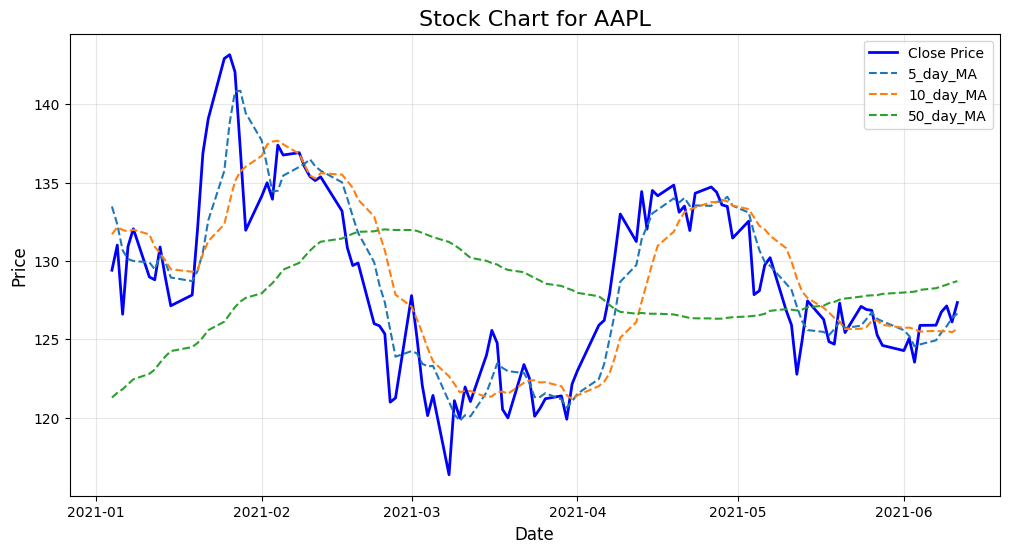

In [158]:
plot_stock_chart(stock_data_tidy, ticker='AAPL', start_date='2021-01-01', end_date='2022-12-31')